The purpose of this notebook is to collect the *documents* for LDA later on.

I think it makes sense to capture transitions from posts to comments as well as just from comments to comments. For that reason we define a document, in the IR sense, as either a post or a comment. We will gather text bodies of document trees, and their 2-gram transitions. For each subreddit, we can simply traverse each document's tree in DFS order so to accomplish both at the same time. We'll store the each text body in a list, and the transitions as a list of tuples containg the indices of their corresponding text bodies.

I've come back from the future, and realized that I'll also need to define a generator for a document's comments—since it only fetches several at a time. More precisely, it will fetch a list of comments, with a `MoreComments` `praw` object at the end. But, what if I arbitrarily want more comments!? 

In [1]:
def all_comments(comments, limit=100):
    for c in comments:
        if isinstance(c, praw.objects.Comment):
            yield c
            limit -= 1
        else:
            for c in all_comments(c.comments(), limit=limit):
                yield c
                limit -=1
        if limit <= 0:
            raise StopIteration

So it turns out, as a consequence of `praw`'s implementation of replies, that `all_comments` yields comments in "best" sorted order depth-first wise. I've verified this by looking at actual subreddit posts and their corresponding comments. Also satisfying is to see the jagged, power-curve-like decrease in scores:

In [2]:
import praw
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

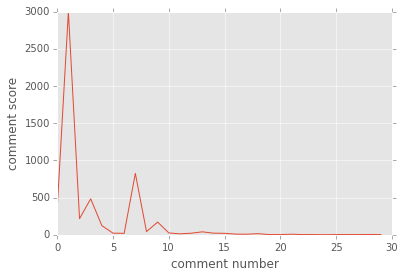

In [3]:
r = praw.Reddit('test')
comments = next(r.get_subreddit('science').get_top_from_all(limit=1)).comments
plt.plot([c.score for c in all_comments(comments, limit=30)])
plt.xlabel('comment number')
plt.ylabel('comment score')
plt.show()

Cool, so the comments seem to come in roughly score-sorted order. This way getting the comments from the top posts of all time, for a given subreddit, will be roughly cut from the same principle.

To start, we'll need an interface to login to Reddit. The API wrapper `praw` suits this need perfectly. Now, to define some functions to gather the comments, and transitions.

In [4]:
from pyprind import ProgPercent

In [5]:
def sub_gather(subreddit, width=5, depth=5):
    docs = []
    trans = []
    r = praw.Reddit('comment LDA')
    sub = r.get_subreddit(subreddit)
    prog = ProgPercent(width)
    for p in sub.get_top_from_all(limit=width):
        docs.append(p.title)
        parent_index = len(docs) - 1    # index of the just added document
        for c in all_comments(p.comments, width):
            comment_recur(c, parent_index, width, depth, docs, trans)
        prog.update()
    return docs, trans

In [6]:
def comment_recur(comment, parent_index, width, depth, docs, trans):
    if comment.body == '[deleted]' or depth <= 0:
        return
    docs.append(comment.body)
    trans.append((parent_index, len(docs) - 1))
    parent_index = len(docs) - 1    # index of th just added document
    for child in all_comments(comment.replies, limit=width):
        comment_recur(child, parent_index, width, depth - 1, docs, trans)

In [7]:
import pickle
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

In [8]:
html = urlopen('http://redditmetrics.com/top')
soup = BeautifulSoup(html, 'html.parser')
raw = soup.get_text()
pat = re.compile(r'/r/(\w+)\n')
top_subs = pat.findall(raw)

In [11]:
width, depth = 10, 3
topn = 20

for subreddit in top_subs[7:topn]:
    print(subreddit, flush=True)
    docs, trans = sub_gather(subreddit, width=width, depth=depth)
    with open('docs/{}[{}-{}].p'.format(subreddit, width, depth), 'wb') as f:
        pickle.dump((subreddit, docs, trans), f)

IAmA


[ 50 %] elapsed[sec]: 487.092 | ETA[sec]: 487.092 

AssertionError: 